In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = next(left.select_traces())
    t2 = next(right.select_traces())
    _clear_props([t1, t2])
    fig.add_trace(t1, row=1, col=1)
    fig.add_trace(t2, row=1, col=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [3]:
runners = pd.read_csv('data/cherryBlossomMen.csv')
dogs = pd.read_csv('data/akc.csv').dropna()

sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)

def subset(df):
    return df.loc[(df['price'] < 4_000_000) &
                  (df['bsqft'] < 12_000)]

def log_vals(sfh):
    return sfh.assign(log_price=np.log10(sfh['price']),
                      log_bsqft=np.log10(sfh['bsqft']),
                      log_lsqft=np.log10(sfh['lsqft']))

def clip_br(sfh):
    eight_up = sfh.loc[sfh['br'] >= 8, 'br'].unique()
    new_bed = sfh['br'].replace(eight_up, 8)
    return sfh.assign(br=new_bed)

sfh = (sfh_all
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
)

b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


(ch:viz_smoothing)=
# Smoothing and Aggregating Data

When we have lots of data, we often don't want to plot all of the individual
data points.
The scatter plot below shows data from the Cherry Blossom Run, an annual 10-mile run in Washington D.C.
These data were scraped from the Web and include run times for all registered male runners from 1999 to 2012. 
We've put the runner's registered age on the x-axis and race time on the y-axis.

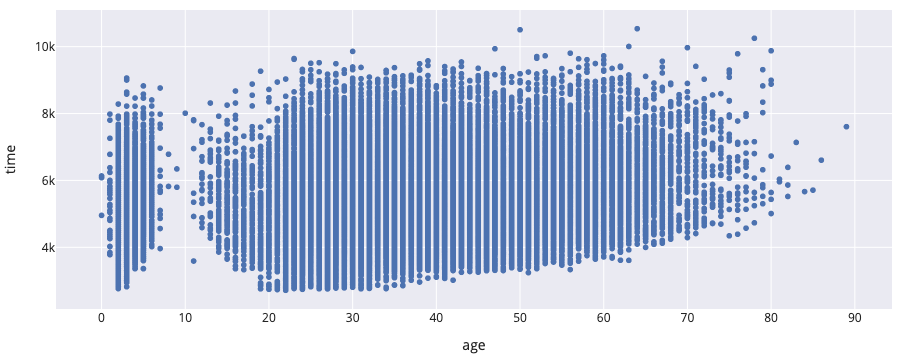

In [4]:
fig = go.Figure(
    data=go.Scattergl(x=runners['age'], y=runners['time'], mode='markers'),
    layout=dict(width=350, height=250),
)
fig.update_xaxes(title_text='age')
fig.update_yaxes(title_text='time')
fig

This scatter plot contains over 70,000 points. 
With so many points, many of them overlap with each other.
This is a common problem called *over-plotting*.
In this case, over-plotting prevents us from seeing how time and age are related.
About the only thing that we can see in this plot is a group of very young runners, which points to issues in the data.
To address over-plotting, we use smoothing techniques that aggregate data together before plotting.

## Smoothing Techniques to Uncover Shape

The histogram is a familiar type of plot that uses smoothing.
A histogram aggregates data values together by putting points into bins and plotting one bar for each bin.
Smoothing here means that we can not differenitate points from each other in a bin.
The area of a bin corresponds to the percentage (or count or proportion) of points in the bin.
Often the bins are equal in width and we take a shortcut to label the height of a bin as the proportion.


The histogram below plots the distribution of lifespans for dog breeds.
Above the histogram is a rug plot that draws a single line for every data value.
We can see in the tallest bin that even a small amount of data can cause overplotting in the rug plot.
By smoothing out the points in the rug plot, the histogram reveals the general shape of the distribution.
In this case, we see that many breeds have a longevity of about 12 years.  For more on how to read and interpret
histograms, see {numref}'Section %s <ch:eda_distributions>'.

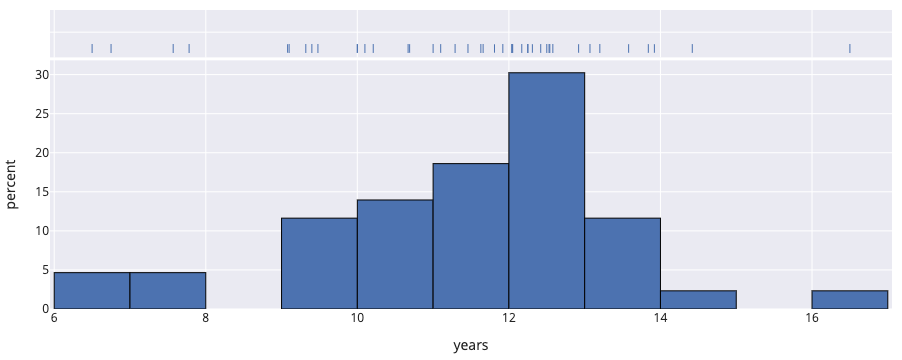

In [5]:
fig = px.histogram(dogs, x="longevity", marginal="rug", nbins=20,
                   labels={"longevity":"years"},
             histnorm='percent', width=350, height=250)
fig.data[0].marker.line =  dict( color = 'black',width = 1)
fig

Another common smoothing technique is *kernel density estimation* (KDE).
A KDE plot shows the distribution using a smooth curve rather than bars.
In the plot below, we show the same histogram of dog longevities
with a KDE curve overlain on top.
We can see the KDE curve shows a similar shape distribution as the histogram.

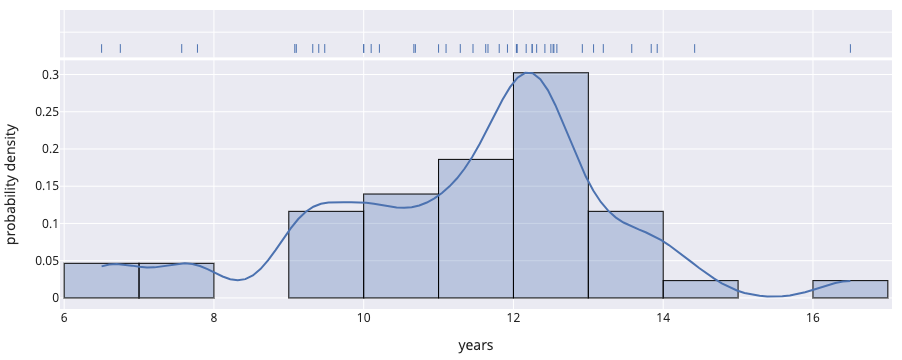

In [6]:
from scipy.stats import gaussian_kde

fig = px.histogram(dogs, x="longevity", marginal="rug",
                   histnorm='probability density', nbins=20,
                   labels={"longevity":"years"},
                   width=450, height=250)

fig.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

fig.data[0].marker.line =  dict( color = 'black',width = 1)

bandwidth = 0.2
xs = np.linspace(min(dogs['longevity']), max(dogs['longevity']), 100)
ys = gaussian_kde(dogs['longevity'], bandwidth)(xs)
curve = go.Scatter(x=xs, y=ys)

fig.add_trace(curve)
fig.update_traces(marker_color='rgb(76,114,176)',
                  selector=dict(type='scatter'))
fig.update_layout(showlegend=False)

What about plots for two variables, like scatter plots? There are similar techniques to histograms and kernel density estimates for smoothing pairs of features. This is the topic of the next section.

## Smoothing Techniques to Uncover Relationships and Trends

We can find high density regions of a scatter plot by binning data, like in a histogram.
The plot below, remakes the earlier scatter plot of the Cherry Blossom race times against age.
(Note that we have dropped the dubious young runners from this plot). 
This plot uses rectangular bins to aggregate points together, and 
then shades the rectangles based on how many points fall in them.

In [7]:
runnersOver17 = runners[runners["age"] > 17]

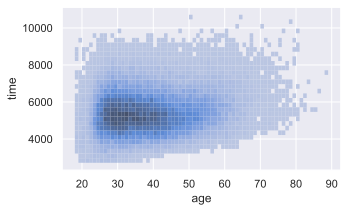

In [8]:
plt.figure(figsize=(5, 3))
sns.histplot(runnersOver17, x='age', y='time', binwidth=[1, 250]);

Notice the high density region in the 25 to 40 age group. 
Many of the runners in this age range complete the race in around 5000 seconds (about 80 minutes).

Kernel density estimation also works in two dimensions.
When we use KDE in two dimensions, we plot the contours of the resulting two-dimensional curve. 
You read this plot like a topographical map.

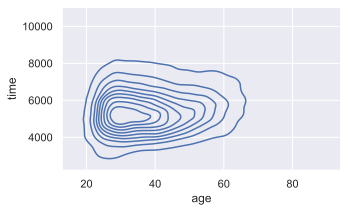

In [9]:
# Takes a while to run!
plt.figure(figsize=(5, 3))
sns.kdeplot(data=runnersOver17, x='age', y='time');

The two-dimensional KDE gives similar insights as the shaded bins. In this example, we see a concentration of runners in the 25 to 40 age group and these runners have times that appear to be roughly 5000 seconds.  
Using smoothing techniques lets us get a better picture of lots of data.
Smoothing can reveal information about the distribution of data values that is hard to otherwise see. 

Another, informative informative approach to smoothing scatter plots that can be easier to read smooths the y-values for points with similar x-value. To explain, let's group together the race times for runners with ages in five-year increments: 20-25, 25-30, 30-35, etc. Then, plot the average time for each group and connect the points. Such a curve appears below.

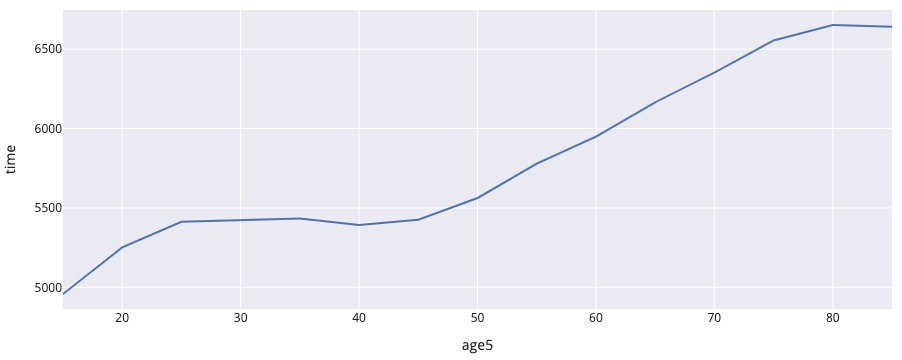

In [10]:
times = (
    runnersOver17.assign(age5=runnersOver17['age'] // 5 * 5)
    .groupby('age5')
    ['time']
    .mean()
    .reset_index()
)

px.line(times, x='age5', y='time', width=350, height=250)

This plot shows once again that runners in the 25 to 40 year age range have typical run times of about 5400 seconds. It also show that older runners took longer to complete the race on average (not really a surprise, but it wasn't evident in the earlier plots). The dip for runners under 20 and the flattening of the curve at 80 may be simply the result of fewer runners who are also fitter runners in these groups. There are also other techniques to view trends that are based on kernel smoothing and splines. We don't go into this topic further. 

Whether using a binning technique or kernel smooth technique, these methods rely on a tuning parameter that specifies the width of the bin or the spread of the kernel. This is the topic of the next section.  

## Smoothing Techniques Need Tuning

Now that we've seen how smoothing is useful for plotting, we turn to the issue of tuning. 
For histograms, the width of the bins or, equivalently, for equal-width bins, the number of bins affect the look of the histogram. 
For example, the left histogram of longevity below has a few wide bins, and the right histogram 
has many narrow bins. In both cases, it's hard to see the shape of the distribution.
With a few wide bins, we have over-smoothed the distribution, which makes it impossible to discern modes and tails. On the other hand, too many narrow bins, gives a plot that's little better than a rug plot.
KDE plots have a parameter called the "bandwidth" that works similarly to the binwidth of a histogram.

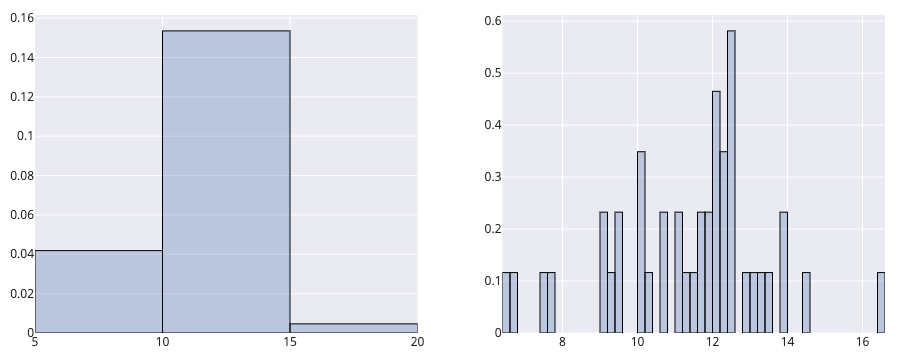

In [11]:
f1 = px.histogram(dogs, x="longevity", nbins=3, histnorm='probability density',
             width=350, height=250)

f1.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

f1.data[0].marker.line =  dict( color = 'black',width = 1)

#bandwidth = 0.5
xs = np.linspace(min(dogs['longevity']), max(dogs['longevity']), 100)
ys = gaussian_kde(dogs['longevity'])(xs)
curve = go.Scatter(x=xs, y=ys)
f1.add_trace(curve)

f2 = px.histogram(dogs, x="longevity", nbins=100, histnorm='probability density',
             width=350, height=250)
f2.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

f2.data[0].marker.line =  dict( color = 'black',width = 1)


left_right(f1, f2, height=250)

Most histogram and KDE software chooses the binwidth and bandwidth automatically, but these often need a bit of fiddling. When you create visualizations that use smoothing, it's important to try a few different smoothing amounts to create the most useful plot.

## Reducing Distributions to Quantiles

We found in {numref}'Chapter %s<ch:eda>' that while box plots aren't as informative as histograms, they can be useful when comparing the distributions of many groups at once. A box plot reduces the data too a few essential features based on the data quartiles. More generally, quantiles (the lower quartile, median, and upper quartile are just the 25th, 50th, and 75th quantiles) can provide a useful reduction in the data for comparing distributions.   

When two distributions are similar, it can be hard to see the differences with histograms.
For instance, the histograms below show two- and four-bedroom house price distributions for the SF housing data. 
The distributions look roughly similar in shape, but it's hard to see whether one distribution is more skewed than another.

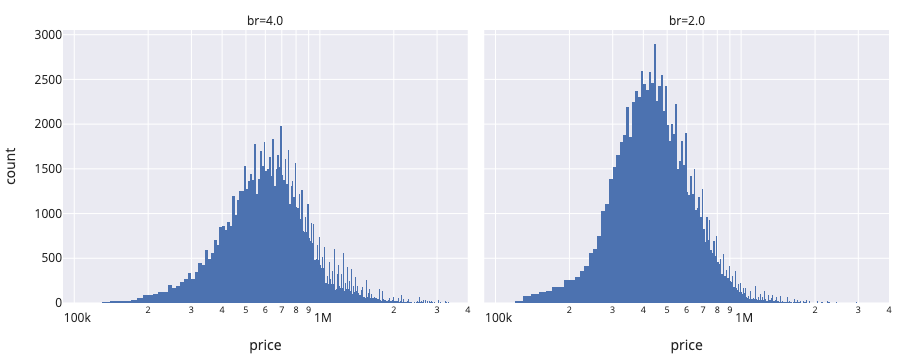

In [12]:
fig = px.histogram(sfh.query('br in [2, 4]'),
                   x='price', log_x=True, facet_col='br', width=700, height=250)
margin(fig, t=30)

Rather than compare histograms, we can compare quantiles with a quantile-quantile plot, called q-q plot for short. To make this plot, we first compute percentiles (also called quantiles) for both distributions.
Then, we plot matching percentiles on a scatter plot. We usually also show the reference line (y = x).

In [13]:
br2 = sfh.query('br == 2')
br4 = sfh.query('br == 4')
percs = np.arange(1, 100, 1)
perc2 = np.percentile(br2['price'], percs, interpolation='lower')
perc4 = np.percentile(br4['price'], percs, interpolation='lower')
perc_sfh = pd.DataFrame({'percentile': percs, 'br2': perc2, 'br4': perc4})
perc_sfh

percentile       br2       br4
0            1  1.50e+05  2.05e+05
1            2  1.82e+05  2.50e+05
2            3  2.03e+05  2.75e+05
..         ...       ...       ...
96          97  1.04e+06  1.75e+06
97          98  1.20e+06  1.95e+06
98          99  1.44e+06  2.34e+06

[99 rows x 3 columns]

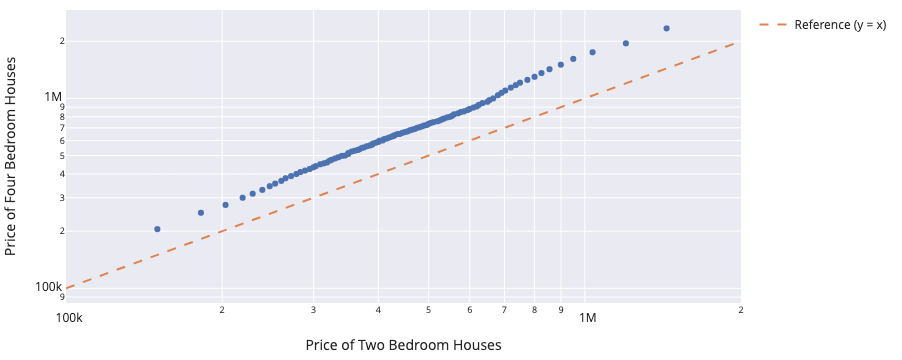

In [14]:
fig = px.scatter(perc_sfh, x='br2', y='br4', log_x=True, log_y=True, width=500, height=350,
                 labels={'br2': 'Price of Two Bedroom Houses',
                         'br4': 'Price of Four Bedroom Houses'})

fig.add_trace(
    go.Scatter(x=[1e5, 2e6], y=[1e5, 2e6], 
               mode='lines', line=dict(dash='dash'),
               name='Reference (y = x)')
)
fig

When the points in the plot fall along a line, the variables have similar shaped distributions.
Lines parallel to the reference indicate a difference in means; lines with slopes other than 1 indicate a difference in spread, and curvature indicates difference in shape. 
From the q-q plot above, we see that the distribution of price for four-bedroom houses is similar in shape to the two-bedroom  distribution, except for a shift of about $\$100K$ in price and a slightly longer right tail. 
Reading a q-q plot takes practice. Once you get the hang of it though, it can be a handy way to compare distributions. 

Notice that the housing data have over 100,000 observations, and the q-q plot has reduced the data to 99 percentiles. 

## When Not to Smooth

Smoothing and aggregating can help us see important features and relationships, but when we have only a handful of observations, smoothing techniques can give misleading representations of the data.  With just a few
observations, we prefer rug plots over histograms, box plots, and density curves, and we use scatter plots rather than smooth curves and density contours. One of the most common misuses of smoothing happens with box plots. For example, below is a collection of seven box plots of longevity, one for each breed group. Some of these boxplots have as few as two or three observations.  

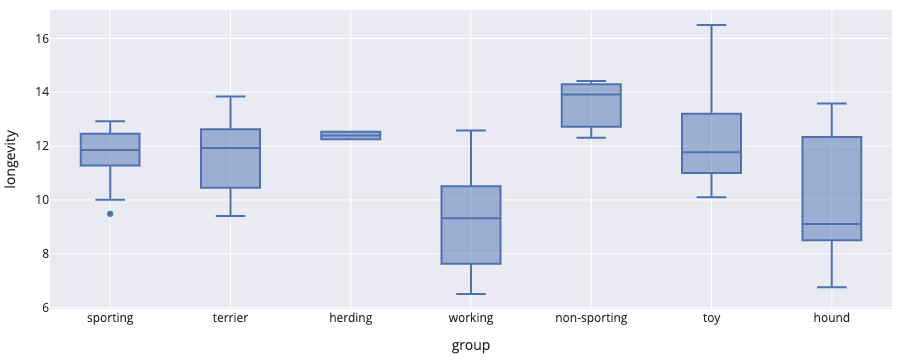

In [15]:
px.box(dogs, x='group', y='longevity', width=500, height=250)

The strip plot below is preferrable visualization. We can still compare the groups, but we can also see the exact value for each group. For example, we see there are only three breeds in the non-sporting group, and the impression of a skewed distribution based on the corresponding box plot would be reading too much into the box.  

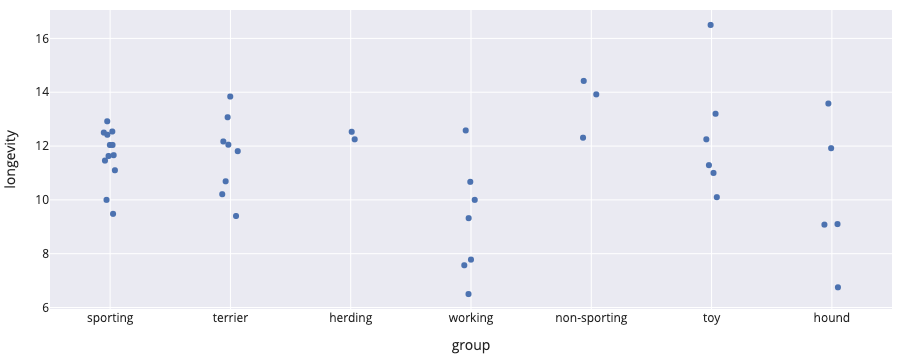

In [16]:
px.strip(dogs, x="group", y="longevity", )

There are plenty of other ways to reduce over-plotting in scatter plots.
For instance, we can make the dots partially transparent so overlapping points appear darker.
If many observations have the same values (e.g., when measurements are rounded to the nearest inch),
then we can add a small amount of random noise to the values to reduce the amount of over-plotting. 
This procedure is called "jittering" (it is used in the strip plot above).
Transparency and jittering are convenient for medium-sized data.
However, they don't work very well for large datasets since they still plot
all the points in the data.

This section introduced the problem of over-plotting, where we have overlapping points because of a large dataset. To address this issue, we introduced smoothing techniques that aggregate data together.
We saw two common examples of smoothing: binning and kernel smoothing, and applied them in the one- and two-dimensional settings. In one-dimension, these are histograms and kernel density curves, and they both help us see distributions. 
In two dimensions, we examined binning to create contours that show high denisty regions through 
color (the histogram approach) and topographical curves (the kernel approach). 
Additionally, we discussed how to smooth y-values while keeping x-values fixed in order to visualize trends in the data, and how to compare distributions with quantile-quantile plots. 
We addressed the need to tune the smoothing amount to get more informative histograms and density curves, and we cautioned against smoothing with too few data. 

The quantile-quantile plot we introduced in this section offers one way to compare distributions, another is to use side-by-side box plots. In the next section, we'll discuss several principles for designing visualizations that facilitate meaningful comparisons for a variety of plot types.